In [1]:
import os
import sys
import numpy as np
import pandas as pd

from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.discretisation.arbitrary import ArbitraryDiscretiser
from feature_engine.selection import DropFeatures
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import RecursiveFeatureAddition
from feature_engine.encoding import MeanEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler , MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline 
from sklearn.feature_selection import SequentialFeatureSelector

s_path = os.path.dirname(os.path.realpath(__file__))
sys.path.append(s_path)

pd.set_option('display.max_columns',100)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import tm_teoriaMvto_base_prep as base_prep
import tm_teoriaMvto_label as tm_label
import tm_teoriaMvto_train as tm_train
import tm_teoriaMvto_ft_eng as ft_eng
# import tm_teoriaMvto_ft_sel as ft_sel

# models to test
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# optimizing ensemble
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import forest_minimize
from skopt.callbacks import DeltaYStopper



In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\n

In [2]:
path_files = os.path.join(s_path, 'historical_files')

# base prep control
EXPORT_X = False
EXPORT_Y = False

# params labeling
s_prefix = 'ft_'
s_lbl_type = 'c_binary'
f_th = 0.2
b_dist = True
b_percent = True
b_custom = True

# params loading
s_regime = 'mi_up'



In [3]:
if EXPORT_X:
  df_data = base_prep.import_sampling(path_files= os.path.join(path_files, 'FeaturesFiles'), prefix_files= s_prefix)

  # create new features before extracting samples - using full data needed by lag features
  df_data = ft_eng.BasicFeatures().transform(X=df_data)

  df_X = base_prep.ft_export(df_data, path_files= os.path.join(path_files, 'TrainFiles'), prefix= s_prefix)
  y_sc = base_prep.y_export(df_data, path_files= os.path.join(path_files, 'TrainFiles'), prefix= s_prefix)



In [4]:
y_config = 'prefix_'+ s_prefix +'_type_'+ s_lbl_type +'_th_'+ str(f_th) +'_dist_'+ str(b_dist) +'_percent_'+str(b_percent)+'_custom_'+str(b_custom)

if EXPORT_Y:
  df_label = None 
  if EXPORT_X: df_label = y_sc

  # specify df_data = None (default) to load pickle from s_path + 'y_prep_data.pkl'
  label = tm_label.Labeling(df_data = df_label, label_type= s_lbl_type, b_dist_to_high= b_dist, 
                            s_path = os.path.join(path_files, 'TrainFiles'), prefix_files = s_prefix, th_label_y1=f_th, 
                            b_percent_freq=b_percent, b_custom_dir=b_custom)

  df_y = label.apply_label(s_model_return = s_regime)  # it will export 4 pickle files to label_obj.s_path
  # y_config = label.s_name

y_outfile = os.path.join(os.path.join(path_files, 'TrainFiles'), 'y_' + y_config +'.pkl')

if os.path.exists(y_outfile):
  print('y outfile ready for configuration: {}'.format(y_config))
else:
  print('WARNING: y outfile not found for configuration. Define EXPORT_Y = True and try again {}'.format(y_config))



y outfile ready for configuration: prefix_ft__type_c_binary_th_0.2_dist_True_percent_True_custom_True


In [5]:
l_prop_08 = ['escora_bid_2.5_0.8', 'escora_ask_2.5_0.8', 'escora_bid_3.5_0.8', 
            'escora_ask_3.5_0.8', 'escora_bid_4.5_0.8', 'escora_ask_4.5_0.8', ]

l_prop_12 = ['escora_bid_2.5_1.2', 'escora_ask_2.5_1.2', 'escora_bid_3.5_1.2',
            'escora_ask_3.5_1.2', 'escora_ask_4.5_1.2', 'escora_bid_4.5_1.2', ]

l_prop_2 = [ 'escora_bid_2.5_2', 'escora_ask_2.5_2', 'escora_bid_3.5_2',
            'escora_ask_3.5_2', 'escora_bid_4.5_2', 'escora_ask_4.5_2', ]

l_col_log = ['agg_net_d', 'aggbig_net_d', 'vol_trd', 'vol_big', 'big_v', 'vol_trd_aux', 
   'vol_big_aux', 'big_v_aux', 'loc_agg_net_d', 'big_c', 'big_c_aux',
   'loc_aggbig_net_d', 'agg_net_m', 'agg_net_m_aux', 'abagg', 'abagg_aux',
   'aggbig_net_m', 'aggbig_net_m_aux', 'loc_agg_net_m', 'loc_aggbig_net_m',
   'loc_agg_net_m_aux', 'loc_aggbig_net_m_aux', 'loc_aggbig_c_m', 'loc_aggbig_v_m', 
   'loc_aggbig_c_m_aux', 'loc_aggbig_v_m_aux', 'abs_v', 'abs_c', 'aggpior_v', 'aggpior_v_aux', 
   'aggpior_c', 'aggpior_c_aux', 'agg_net_10', 'agg_net_40', 'agg_net_80', 'loc_agg_net_10',
   'aggbig_net_10', 'aggpior_DIF', 'aggpior_DIF_30', 'abs_DIF', 'abs_DIF_30',
   'abagg_10', 'aggpior_aux_DIF', ]

l_side_drop = ['big_c','big_v','aggpior_c','aggpior_v','loc_aggbig_c_m','loc_aggbig_v_m','pagg_c_best',
  'pagg_c_best_0.5','pagg_c_best_0.7','pagg_c_best_0.9','pagg_v_best','pagg_v_best_0.5','pagg_v_best_0.7',
  'pagg_v_best_0.9','abs_c','abs_v','int_c','int_c_0.6','int_c_0.7','int_c_0.8','int_c_0.9','int_dif_c',
  'int_v','int_v_0.6','int_v_0.7','int_v_0.8','int_v_0.9','int_dif_v','imp_c','imp_c_0.6','imp_c_0.7',
  'imp_c_0.8','imp_c_0.9','imp_v','imp_v_0.6','imp_v_0.7','imp_v_0.8','imp_v_0.9','escora_bid_2.5_1.2',
  'escora_bid_2.5_2','escora_ask_2.5_1.2','escora_ask_2.5_2','escora_bid_3.5_1.2','escora_bid_3.5_2',
  'escora_ask_3.5_1.2','escora_ask_3.5_2','escora_bid_4.5_0.8','escora_bid_4.5_2','escora_ask_4.5_0.8',
  'escora_ask_4.5_2','movesc_bid_2.5','movesc_ask_2.5','movesc_bid_2.5_0.5','movesc_ask_2.5_0.5',
  'movesc_bid_2.5_0.7','movesc_ask_2.5_0.7','movesc_bid_3.5','movesc_ask_3.5','movesc_bid_3.5_0.7',
  'movesc_ask_3.5_0.7','movesc_bid_3.5_0.9','movesc_ask_3.5_0.9','movesc_bid_4.5','movesc_ask_4.5',
  'movesc_bid_4.5_0.5','movesc_ask_4.5_0.5','movesc_bid_4.5_0.7','movesc_ask_4.5_0.7','depth_bid7','depth_ask7'
  ]

l_side_drop_aux = ['big_c_aux','big_v_aux','aggpior_c_aux','aggpior_v_aux','loc_aggbig_c_m_aux',
  'loc_aggbig_v_m_aux','pagg_c_best_aux','pagg_c_best_0.5_aux','pagg_c_best_0.7_aux',
  'pagg_c_best_0.9_aux','pagg_v_best_aux','pagg_v_best_0.5_aux', 'pagg_v_best_0.7_aux',
  'pagg_v_best_0.9_aux'
  ]

l_ft_aux = [
  'vol_trd_aux', 'n_trd_aux','vol_big_aux','n_big_aux','vol_big_ratio_aux','big_c_aux','big_v_aux',
  'aggpior_c_aux','aggpior_v_aux','aggimb_aux','aggimb_big_aux','n_aggimb_aux','agg_net_m_aux',
  'aggbig_net_m_aux','loc_aggbig_c_m_aux','loc_aggbig_v_m_aux','loc_agg_net_m_aux','loc_aggbig_net_m_aux',
  'loc_agg_imb_m_aux','loc_aggbig_imb_m_aux','pagg_c_best_aux','pagg_c_best_0.5_aux','pagg_c_best_0.7_aux',
  'pagg_c_best_0.9_aux','pagg_v_best_aux','pagg_v_best_0.5_aux','pagg_v_best_0.7_aux','pagg_v_best_0.9_aux',
  'abagg_aux','n_p_aux','aggpior_aux_DIF','pagg_aux_DIF'
  ]



In [6]:
test_size = 0.2

if not EXPORT_X:
  df_X = tm_train.load_models('X_samples_'+s_prefix, os.path.join(path_files, 'TrainFiles'))  # search for path_files/s_regime.pkl

X = df_X.loc[df_X['model'] == s_regime].drop(columns='model')

if not EXPORT_Y:
  df_y = tm_train.load_models('y_' + y_config, os.path.join(path_files, 'TrainFiles'))
  y = df_y.loc[df_y['model'] == s_regime].drop(columns='model')
else:
  y = df_y.drop(columns='model')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)

print('load_split: X, y data load and split complete!')



load_split: X, y data load and split complete!


In [7]:
# DEBUG: prop_features contaning np.NaN = (pd.isna(X_train).sum()>0).sort_values(ascending=False).head(50)
X_train = ft_eng.PropImputer(0.8, l_prop_08).transform(X_train)
X_train = ft_eng.PropImputer(1.2, l_prop_12).transform(X_train)
X_train = ft_eng.PropImputer(2, l_prop_2).transform(X_train)

median_inputer = MeanMedianImputer(variables=['PA_down',])
X_train = median_inputer.fit_transform(X_train)

nan_imputer = ArbitraryNumberImputer(0.0, variables=['ohlc_10','ohlc_50'])
X_train = nan_imputer.fit_transform(X_train)

X_train = ft_eng.DifAll().transform(X_train)
X_train = ft_eng.LogVolume(l_col_log).transform(X_train)

if s_regime[:2] == 'mw':
  # for now, removing all side columns
  l_cols_drop = l_side_drop + l_ft_aux + ['smart_price', 'sspread']
else:
  l_cols_drop = l_side_drop + l_side_drop_aux + ['s_run', 'n_p_aux', 'smart_price', 'sspread']

# TODO: INCREMENTAR L COLS DROP TAMBEM QUANDO LABEL NAO FOR DIST-TO-HIGH, RETIRANDO AS COLUNAS DE VARIACAO DE PRECO!

X_train.drop(columns=l_cols_drop, inplace=True)


In [8]:
X_test = ft_eng.PropImputer(0.8, l_prop_08).transform(X_test)
X_test = ft_eng.PropImputer(1.2, l_prop_12).transform(X_test)
X_test = ft_eng.PropImputer(2, l_prop_2).transform(X_test)

X_test = median_inputer.transform(X_test)

X_test = nan_imputer.transform(X_test)

X_test = ft_eng.DifAll().transform(X_test)
X_test = ft_eng.LogVolume(l_col_log).transform(X_test)

X_test.drop(columns=l_cols_drop, inplace=True)



In [9]:

# TODO: move function to ft_selection.py
def list_sub(lst1, lst2):
  final_list = list(set(lst1) - set(lst2))
  return final_list


def list_union(*l_lists):
  l_union = l_lists[0]
  if len(l_lists) > 1:
    for i in range(len(l_lists)-1):
      l_union = set(l_union) | set(l_lists[i+1])
  return list(l_union)

l_duplicate = ['loc_agg_net_m',]  # _2 ft comes from ft_eng.duplicate()

l_cap_1 = ['vewma_c_v', 'vewmag_dif', 'book_imb', 'book_imb_dif', ]

l_cap_5 = ['PA_up', 'PA_down', ]

l_cap_10 = ['n_big_aux', ]

l_cap_default = list_sub(X_train.columns.to_list(), list_union(l_cap_1, l_cap_5, l_cap_10))

l_bins_q2 = ['loc_agg_net_m_2',]  # _2 ft comes from ft_eng.duplicate()

l_bins_q4 = ['ohlc_10','ohlc_50',]

l_bins_q5 = ['loc_aggbig_net_m','vol_trd_aux','aggbig_net_m_aux','book_imb','rng_ewma_dif',
            'rng_ewma_dif_40','rng_ewma_dif_80','vewma_10','vewma_g_p_10','aggbig_net_10',
]

l_bins_q6 = ['agg_net_d', 'aggbig_net_d', 'loc_agg_imb_m_aux',]

l_bins_q8 = ['rng_ewma','vewma_g_p','vewmag_dif','n_trd_aux','abagg_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8',
            'escora_bid_3.5_0.8','escora_ask_3.5_0.8','escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_2.5_0.9',
            'movesc_ask_2.5_0.9','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','movesc_bid_4.5_0.9','movesc_ask_4.5_0.9',
            'msg_imb','rng_smart_10','imp_DIF_10','imp_DIF_50','agg_net_80','imp_FCAST_40','aggpior_DIF',
            'book_imb_mean_dif_cp','msg_imb_mean_10','escora_4.5_0.8_DIF',
]

l_bins_q10 = ['vol_big_ratio','aggimb','n_aggimb','agg_net_m','loc_aggbig_imb_m','abagg','n_p','vewma',
            'vewma_c_v', 'aggimb_aux','aggimb_big_aux','agg_net_m_aux','loc_aggbig_net_m_aux','smart_price_dif',
            'smart_price_50','rng_smart_50','agg_net_10','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10',
            'book_imb_mean_10','book_imb_mean_dif_lp','msg_imb_mean_40','msg_imb_mean_dif_lp','msg_imb_mean_dif_cp',
            'sspread_mean','movesc_2.5_0.7_DIF','msg_imb_mean_40_ABS','loc_agg_net_m',
] 

d_bins_arbitrary = {
            'n_trd':  [-0.01, 70, 180, 280, 380, 5000000],
            'vol_trd':  [0, 7.237, 7.55, 10000],
            'aggimb_big':		[-1.1, -0.4, 0.4, 1.1],
            'aggbig_net_m':		[-10000, -5, +10000],
            'chgfreq':		[-0.01, 0.167, 0.280, 1.01],
            'last_d_s':		[-1.01, -0.5, 0.5, 1.01],
            'loc_agg_net_d':		[-10000, -6.4, 5.2, 5.7, 10000],
            'loc_aggbig_net_d':		[-10000, -5.4, -3.8, 10000],
            'n_big_aux':	[-0.01, 3.1, 1000],
            'vol_big_ratio_aux':		[-0.01, 0.275, 0.520, 1.01],
            'loc_agg_net_m_aux':		[-10000, -4.451, -3.592, -2.435, 3.607, 10000] ,
            'loc_aggbig_imb_m_aux':		[-1.1, -0.99, -0.391, -0.0118, 0.4, 0.99, 1.1],
            'aggpior_DIF_30':		[-10000, -4.454, -4.111, -3.829, -3.26, -3.05, -3.04, -0.01, 0.01, 3.714, 10000],
            'abs_DIF':		[-10000, -4.796, -4.19, -0.1, 0.1, 2.398, 4.564, 10000],
            'pagg_DIF':	[-1.1, -0.95, -0.6, -0.4, -0.001, 0.001, 0.4, 0.6, 0.95, 1.1],
            'book_imb_dif':	[-1000, -27, -14, -6.8, -2.5, 0.1, 4.29, 11.2, 22, 1000],
            'book_imb_mean_40': [-10000, -30, -20, -16, 10000],
            'aggpior_aux_DIF':		[-10000, -4.331, -3.584, -3.045, -0.01, 0.01, 3.045, 10000] ,
            'pagg_aux_DIF':		[-1.1, -0.95, -0.5, -0.001, 0.001, 0.5, 0.95, 1.1],
            'escora_3.5_1.2_DIF':		[-1.1, -0.171, -0.0482, 0, 0.0482, 0.0927, 1.1],
            'movesc_3.5_0.7_DIF':		[-10000, -4.451, -1.391, -0.146, 0.0, 0.312, 10000],
            'book_imb_mean_dif_cp_ABS':		[-0.01, 0.119, 10000],
            'msg_imb_mean_dif_lp_ABS':		[-0.01, 0.281, 1.1],
            'loc_agg_imb_m':  [-1.01, -0.491, -0.366, -0.288, -0.223, -0.167, 1.01],
            'imp_FCAST_10': [-10000, -3.012, -1.674, -0.653, 10000],
}

l_bins_nulls = ['vol_big','n_big','PA_up','PA_down','vol_big_aux','n_aggimb_aux','imp_DIF','int_DIF',
                'int_DIF_50','abs_DIF_30','msg_imb_dif','depth_DIF',
                'depth_DIF_10','book_imb_mean_us_5','book_imb_mean_us_20','sspread_mean_us_5',
                'escora_2.5_2_DIF','movesc_4.5_0.7_DIF', 
                # TODO: 's_run', 'n_p_aux' treat for MW
]

# ft classification based on mean encoding 
l_alta = ['pagg_DIF','loc_agg_net_m_aux','aggpior_aux_DIF','loc_agg_imb_m','vol_big_ratio','aggimb',
             'n_aggimb','agg_net_m','loc_aggbig_imb_m','n_p','vewma','agg_net_m_aux','smart_price_dif',
             'smart_price_50','agg_net_10','msg_imb_mean_40_ABS','ohlc_10','ohlc_50','loc_aggbig_net_m',
             'vol_trd_aux','aggbig_net_m_aux','rng_ewma_dif_80','vewma_10','rng_ewma','vewma_g_p','vewmag_dif',
             'n_trd_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8','escora_bid_3.5_0.8','escora_ask_3.5_0.8'
             ,'escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','msg_imb','rng_smart_10',
]

l_media = ['last_d_s','aggimb_big','loc_aggbig_imb_m_aux','pagg_aux_DIF','movesc_3.5_0.7_DIF','abs_DIF',
              'book_imb_mean_dif_cp_ABS','book_imb_dif','abagg','vewma_c_v','aggimb_aux','loc_aggbig_net_m_aux',
              'rng_smart_50','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10','msg_imb_mean_dif_cp',
              'sspread_mean','movesc_2.5_0.7_DIF','loc_agg_net_m','book_imb','rng_ewma_dif','rng_ewma_dif_40',
              'vewma_g_p_10','aggbig_net_10','vol_trd','loc_agg_imb_m_aux','movesc_bid_2.5_0.9','movesc_ask_2.5_0.9',
              'movesc_bid_4.5_0.9','movesc_ask_4.5_0.9','imp_DIF_10','imp_FCAST_40','aggpior_DIF','book_imb_mean_dif_cp',
              'msg_imb_mean_10',
]

# best features from RecursiveFeatureAdd/RandomForest, threshold= 0.002
l_best = ['ohlc_50', 'vewma', 'vewmag_dif', 'rng_smart_10', 'ohlc_10',
          'loc_agg_imb_m', 'aggpior_DIF', 'agg_net_10', 'smart_price_dif',
          'escora_bid_3.5_0.8', 'msg_imb_mean_40_ABS'
]

l_ambas = ['movesc_ask_2.5_0.9', 'smart_price_dif', 'ohlc_50', 'ohlc_10',
           'movesc_bid_2.5_0.9', 'loc_agg_imb_m', 'loc_agg_net_m_aux', 'rng_smart_10',
]

l_tm = ['chgfreq','msg_imb_mean_dif_cp','pagg_aux_DIF','msg_imb','imp_FCAST_10','imp_FCAST_40',]

l_linear = ['pagg_DIF','vol_trd','vewmag_dif','msg_imb_mean_40_ABS','n_p','rng_ewma_dif',]

l_tree=['agg_net_10', 'vewma', 'vewma_c_v', 'agg_net_40', 'imp_DIF_10', 'book_imb_mean_dif_cp',]

l_best_svm = ['smart_price_dif', 'ohlc_50', 'chgfreq','movesc_ask_2.5_0.9']

l_second_svm = ['vewmag_dif', 'msg_imb', 'vol_trd', 'n_p', 'ohlc_10',
                'msg_imb_mean_40_ABS', 'loc_agg_net_m_aux_me', 'loc_agg_imb_m_me',
                'pagg_DIF_me', 'pagg_aux_DIF_me']


In [10]:
pipe_cap_outliers = Pipeline([
                ('cap1', Winsorizer(variables=l_cap_1, capping_method='quantiles', fold = 0.01, tail = 'both')),
                ('cap5', Winsorizer(variables=l_cap_5, capping_method='quantiles', fold = 0.05, tail = 'both')),
                ('cap10', Winsorizer(variables=l_cap_10, capping_method='quantiles', fold = 0.10, tail = 'both')),
                ('cap001', Winsorizer(variables=l_cap_default, capping_method='quantiles', fold = 0.001, tail = 'both')),
])

pipe_norm_scale = Pipeline([
                ('scaler', SklearnTransformerWrapper(transformer=RobustScaler(quantile_range=(0.10, 0.90)))),
                ('minmax', SklearnTransformerWrapper(transformer=MinMaxScaler())),
                # ('pca', PCA(n_components=30, svd_solver='auto')), 
                # ('isomap', Isomap(n_components=13, n_neighbors=50, n_jobs=-1)),   #  expensive
])

pipe_discrete = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=False, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=False, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=False, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=False, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=False, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=False, q=2, variables=l_bins_q2)),
])

pipe_mean_encoding = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=True, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=True, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=True, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=True, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=True, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=True, q=2, variables=l_bins_q2)),
                        ('mean_enc', MeanEncoder())
])

# X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)
# X_test_pre = pipe_cap_outliers.transform(X_test)

# DEBUG: must return all zeroes 
# pd.isna(X_train_transf).sum().sort_values(ascending=False)


In [11]:
import time 
def epoch2str(epoch):
  # from Fredy
  mlsec = "000"
  if str(epoch).find(".") >= 0:
        mlsec = repr(epoch).split('.')[1][:3]
  return time.strftime(
      '[%Y-%m-%d %H:%M:%S.{}]'.format(mlsec), time.localtime(epoch))

l_svm_opt_results = []  # [n_opt, param_c, param_gamma, best_metric]

# N_OPT = 1
# RUN_MODEL = 'svm'
# RUN_BASE = 'scale_me'  # {'scale', 'discrete', 'me', 'scale_me', 'scale_discrete', }
# FT_BINS = l_ambas   # {l_ambas, l_tree, l_linear, l_tm, l_alta, l_media}
# FT_SCALE = l_ambas
# l_svm_opt_results.append([1, 24.12294736213961, 0.0019248847839615224, 0.598])  



In [12]:
# RUN manually or with forest_minimize SVM high_importance ft (mean encoding + scale) & (discrete + scale)

N_OPT = 10.2  
RUN_MODEL = 'svm'
RUN_BASE = 'scale_me'
FT_BINS = ['ohlc_50', 'loc_agg_imb_m', 'chgfreq', 'imp_FCAST_10']
FT_SCALE = ['rng_smart_10', 'smart_price_dif', 'movesc_ask_2.5_0.9', 'msg_imb_mean_dif_cp', 'pagg_aux_DIF']

# TODO: code discrete and choose pipe based on RUN_BASE instead of FT
print('-------------------------------------------')
print('OPTIMIZATION: {}'.format(N_OPT))
print('Initial time: {}'.format(epoch2str(time.time())))

if isinstance(FT_SCALE,list):
  pipe_s = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_importance', ft_eng.SelectFt(FT_SCALE))
  ])
  pipe_s.fit(X_train, y_train) 
  X_scale = pipe_s.transform(X_train)
  X_test_scale = pipe_s.transform(X_test)

if isinstance(FT_BINS,list):
  if RUN_BASE in ['scale_me','me']:
    pipe_bins = Pipeline([('mean_encoding', pipe_mean_encoding),
                          ('ft_sel_importance', ft_eng.SelectFt(FT_BINS))
    ])  
  else:
    pipe_bins = Pipeline([('discrete', pipe_discrete),
                          ('ft_sel_importance', ft_eng.SelectFt(FT_BINS))
    ])  
  pipe_bins.fit(X_train, y_train) 
  X_me = pipe_bins.transform(X_train)
  X_test_me = pipe_bins.transform(X_test)
  me_cols = [column+'_me' for column in X_me.columns]
  X_me.columns = me_cols

if isinstance(FT_BINS,list) & isinstance(FT_SCALE,list):
  # union features scaled and bins 
  X_opt = X_scale.join(X_me, how='outer', rsuffix='_me', sort=False)
  X_test_opt = X_test_scale.join(X_test_me, how='outer', rsuffix='_me', sort=False)
elif isinstance(FT_BINS,list):
  X_opt = X_me
  X_test_opt = X_test_me
elif isinstance(FT_SCALE,list):
  X_opt = X_scale
  X_test_opt = X_test_scale
else:
  print('\nOptimization Warning: Please, specify a list() for FT_BINS and/or FT_SCALE!')


svm_opt = SVC(probability=True, cache_size=1000, verbose=0,
              class_weight='balanced', C=24.52576682827659, gamma=0.0035487626882929166)

# svm_opt = Pipeline([('pca', PCA(n_components=6)),
#                     ('svc', SVC(probability=True, cache_size=1000, verbose=0,
#                               class_weight='balanced', C=33.44, gamma=0.0011))
# ])

svm_opt.fit(X_opt, np.ravel(y_train))
l_results = tm_train.report_results(X_opt, X_test_opt, y_train, y_test, fitted_model=svm_opt, ready_probs=False, th=0)



-------------------------------------------
OPTIMIZATION: 10.2
Initial time: [2021-06-08 16:38:57.370]
train_auc: 0.6251, test_auc: 0.6000 (overfit: 0.0251)
train_f1:  0.5968, test_f1:  0.5705 (overfit: 0.0263)
train_f*:  0.5286, test_f*:  0.5045 (overfit: 0.0242)
--------
cm_train: 
[[3241 3790]
 [1467 3891]]
cm_test: 
[[798 982]
 [400 918]]
threshold: 0.420


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 112.9794
Function value obtained: 0.4295
Current minimum: 0.4295
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 113.0849
Function value obtained: 0.4295
Current minimum: 0.4295
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 111.0959
Function value obtained: 0.4199
Current minimum: 0.4199
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 105.2723
Function value obtained: 0.4053
Current minimum: 0.4053
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 111.1948
Function value obtained: 0.4295
Current minimum: 0.4053
Iteration No: 6 started. 

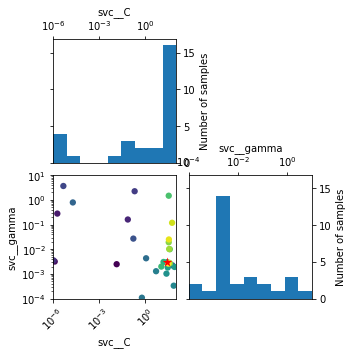

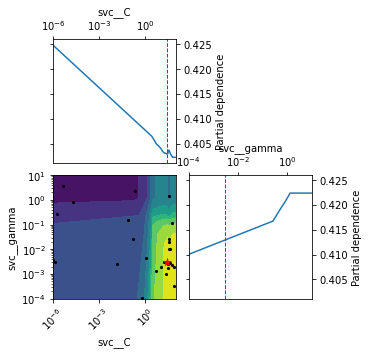

In [13]:
train_obj = tm_train.ModelTraining()
train_obj.optimized_training(X_opt, y_train, 'svm', svm_opt, pipe=False, n_calls=50)
C_opt = train_obj.result_opt.x[0]
gamma_opt = train_obj.result_opt.x[1]
l_svm_opt_results = [[N_OPT, C_opt, gamma_opt, 1-train_obj.result_opt.fun],]
# l_svm_opt_results.append([N_OPT, C_opt, gamma_opt, 1-train_obj.result_opt.fun]) 

# svm_opt.set_params(svc__C=C_opt, svc__gamma=gamma_opt)
svm_opt.set_params(C=C_opt, gamma=gamma_opt)
svm_opt.fit(X_opt, np.ravel(y_train))

print('\nModel results for optimum C: {} and gamma: {}: '.format(C_opt, gamma_opt))
l_results = tm_train.report_results(X_opt, X_test_opt, y_train, y_test, fitted_model=svm_opt, ready_probs=False, th=0)

print('\nFinal time: {}'.format(epoch2str(time.time())))

# export l_results
pd.DataFrame(l_svm_opt_results, columns=['N_OPT', 'C_opt', 'gamma_opt', 'result']).to_csv(os.path.join(s_path,'l_svm_opt_results.csv'), mode='a', header=False)
# df_forest = pd.DataFrame(train_obj.result_opt.x_iters, columns=['svm__C', 'svm__gamma'])
# df_forest['x'] = train_obj.result_opt.func_vals

from skopt.plots import plot_evaluations
_ = plot_evaluations(train_obj.result_opt, bins=10)

from skopt.plots import plot_objective
_ = plot_objective(train_obj.result_opt)


In [14]:
N_ENS = 1

print('-------------------------------------------')
print('OPTIMIZING ENSEMBLE: {}'.format(N_ENS))
print('Initial time: {}'.format(epoch2str(time.time())))

pipe_s = Pipeline([('cap_outliers', pipe_cap_outliers),
                  ('norm_scale', pipe_norm_scale)
                  ])
pipe_s.fit(X_train, y_train) 
X_scale = pipe_s.transform(X_train)
X_test_scale = pipe_s.transform(X_test)

pipe_mean_encoding.fit(X_train, y_train) 
X_me = pipe_mean_encoding.transform(X_train)
X_test_me = pipe_mean_encoding.transform(X_test)

pipe_discrete.fit(X_train, y_train) 
X_d = pipe_discrete.transform(X_train)
X_test_d = pipe_discrete.transform(X_test)

X_ens_opt = X_scale.join(X_me, how='outer', rsuffix='_me', sort=False).join(X_d, how='outer', rsuffix='_d', sort=False)
X_ens_opt_test = X_test_scale.join(X_test_me, how='outer', rsuffix='_me', sort=False).join(X_test_d, how='outer', rsuffix='_d', sort=False)

# feature selection for ensemble models
d_run_models = {'xgb1': 'scale_discrete',    # based on this, specify _d or _me for discrete or mean encoding
                'svm1': 'scale_me'           # on d_ft_bins below
}

d_ft_bins = {'xgb1': ['smart_price_dif_d','chgfreq_d','agg_net_10_d','book_imb_mean_dif_cp_ABS_d',],
             'svm1': ['ohlc_50', 'loc_agg_imb_m', 'chgfreq', ]   
}

d_ft_scale = {'xgb1': ['smart_price_dif','ohlc_10','chgfreq','agg_net_10',],
              'svm1': ['imp_FCAST_10', 'rng_smart_10', 'smart_price_dif', 'movesc_ask_2.5_0.9', 'msg_imb_mean_dif_cp', 'pagg_aux_DIF']
}



-------------------------------------------
OPTIMIZING ENSEMBLE: 1
Initial time: [2021-06-08 18:41:17.636]


In [15]:
from sklearn.metrics import fbeta_score, make_scorer
f_beta_scorer = make_scorer(fbeta_score, beta=0.5)


In [16]:

l_estimators = [
              ('svm1',Pipeline([('ft_sel', DropFeatures(list_sub(X_ens_opt.columns.to_list(),d_ft_scale['svm1']+d_ft_bins['svm1']))),
                                ('clf', SVC(probability=True, 
                                          class_weight='balanced', cache_size=1000, 
                                          C=24.84969151880429, 
                                          gamma= 0.0030157367155080337))])
              ), 
              ('xgb1', Pipeline([('ft_sel', DropFeatures(list_sub(X_ens_opt.columns.to_list(),d_ft_scale['xgb1']+d_ft_bins['xgb1']))),
                                ('clf', XGBClassifier(objective='binary:logistic', eval_metric='auc', 
                                                      use_label_encoder=False, tree_method='auto'
                                                      ,max_depth=5
                                                      ,subsample=0.7
                                                      ,colsample_bytree=0.99999
                                                      ,min_child_weight=25
                                                      ,learning_rate=0.0015
                                                      ,n_estimators=1100
                                                      ,gamma=3
                                                      ,reg_alpha=2
                                                      ,scale_pos_weight=4))])
              ), 
]

ens_opt = StackingClassifier(estimators=l_estimators, 
                              final_estimator=LogisticRegression(),
                              passthrough=False, cv=3, verbose=1, n_jobs=-1
                              )

ens_opt.fit(X_ens_opt, y_train)
print('\nEnsemble results for fixed parameters: ')
l_results = tm_train.report_results(X_ens_opt, X_ens_opt_test, y_train, y_test, fitted_model=ens_opt, ready_probs=False, th=0)



C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

Ensemble results for fixed parameters: 
train_auc: 0.6377, test_auc: 0.6057 (overfit: 0.0320)
train_f1:  0.5748, test_f1:  0.5382 (overfit: 0.0366)
train_f*:  0.5369, test_f*:  0.5148 (overfit: 0.0222)
--------
cm_train: 
[[3929 3102]
 [1946 3412]]
cm_test: 
[[1042  738]
 [ 561  757]]
threshold: 0.450


In [17]:

l_estimators = [
              ('svm1',Pipeline([('ft_sel', DropFeatures(list_sub(X_ens_opt.columns.to_list(),d_ft_scale['svm1']+d_ft_bins['svm1']))),
                                ('clf', SVC(probability=True, 
                                          class_weight='balanced', cache_size=1000, 
                                          C=24.84969151880429, 
                                          gamma= 0.0030157367155080337))])
              ), 
              ('xgb1', Pipeline([('ft_sel', DropFeatures(list_sub(X_ens_opt.columns.to_list(),d_ft_scale['xgb1']+d_ft_bins['xgb1']))),
                                ('clf', XGBClassifier(objective='binary:logistic', eval_metric='auc', 
                                                      use_label_encoder=False, tree_method='auto'
                                                      ,max_depth=5
                                                      ,subsample=0.7
                                                      ,colsample_bytree=0.99999
                                                      ,min_child_weight=25
                                                      ,learning_rate=0.0015
                                                      ,n_estimators=1100
                                                      ,gamma=3
                                                      ,reg_alpha=2
                                                      ,scale_pos_weight=4))])
              ), 
]

ens_opt = StackingClassifier(estimators=l_estimators, 
                              final_estimator=LogisticRegression(dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, 
                                                                random_state=None, max_iter=100, multi_class='auto',
                                                                verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None,
                                                                penalty='l1', solver='liblinear', class_weight='balanced',
                                                                C=20),
                              # final_estimator=MajorityVote(),
                              # final_estimator=KNeighborsClassifier(),
                              passthrough=False, cv=3, verbose=1, n_jobs=-1
                              )

ens_opt.fit(X_ens_opt, y_train)
print('\nEnsemble results for fixed parameters: ')
l_results = tm_train.report_results(X_ens_opt, X_ens_opt_test, y_train, y_test, fitted_model=ens_opt, ready_probs=False, th=0)



C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

Ensemble results for fixed parameters: 
train_auc: 0.6382, test_auc: 0.6054 (overfit: 0.0328)
train_f1:  0.5765, test_f1:  0.5363 (overfit: 0.0402)
train_f*:  0.5375, test_f*:  0.5118 (overfit: 0.0258)
--------
cm_train: 
[[3914 3117]
 [1926 3432]]
cm_test: 
[[1032  748]
 [ 561  757]]
threshold: 0.520


In [20]:
search_space = list()
param_name = []

### final estimator
param_name.append('logit_C') 
search_space.append(Real(0, 100.0, 'log-uniform', name='logit_C'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):

  ens_opt = StackingClassifier(estimators=l_estimators, 
                                final_estimator=LogisticRegression(dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, 
                                                                  random_state=None, max_iter=100, multi_class='auto',
                                                                  verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None,
                                                                  penalty='l1', solver='liblinear', class_weight='balanced',
                                                                  C=params['logit_C']),
                                # final_estimator=MajorityVote(),
                                # final_estimator=KNeighborsClassifier(),
                                passthrough=False, cv=3, verbose=1, n_jobs=-1
                                )

  cv_results = cross_validate(ens_opt, X_ens_opt, y_train, cv=4, n_jobs=-1, scoring=f_beta_scorer, return_train_score= True)
  
  overfit_devs = abs(cv_results['train_score'].mean() - cv_results['test_score'].mean())
  estimate = cv_results['test_score'].mean() - cv_results['test_score'].std() / 4 - overfit_devs / 3

  return 1.0 - estimate               


result_ens_opt = forest_minimize(evaluate_model, search_space, n_calls=100, n_jobs=-1, verbose=1, 
                                      kappa=4.00, callback=DeltaYStopper(0.0002, n_best=8))
    
# summarizing finding:
print('\noptimized_ensemble():')
print('Best Metric: %.3f' % (1.0 - result_ens_opt.fun))
for i, val in enumerate(result_ens_opt.x):
  print('{}: {}'.format(param_name[i],val))

print('Time at end: {}'.format(epoch2str(time.time())))



C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\skopt\space\space.py:318: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base,
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\skopt\space\space.py:320: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1006: RuntimeWarning: invalid value encountered in add
  vals = vals * scale + loc
Iteration No: 1 started. Evaluating function at random point.


ValueError: Point ([nan]) is not within the bounds of the space ([(0, 100.0)]).

In [24]:
search_space = list()
param_name = []

### final estimator
param_name.append('logit_C') 
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='logit_C'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):

  ens_opt = StackingClassifier(estimators=l_estimators, 
                                final_estimator=LogisticRegression(dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, 
                                                                  random_state=None, max_iter=100, multi_class='auto',
                                                                  verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None,
                                                                  penalty='l1', solver='liblinear', class_weight='balanced',
                                                                  C=params['logit_C']),
                                # final_estimator=MajorityVote(),
                                # final_estimator=KNeighborsClassifier(),
                                passthrough=False, cv=3, verbose=1, n_jobs=-1
                                )

  cv_results = cross_validate(ens_opt, X_ens_opt, y_train, cv=4, n_jobs=-1, scoring=f_beta_scorer, return_train_score= True)
  
  overfit_devs = abs(cv_results['train_score'].mean() - cv_results['test_score'].mean())
  estimate = cv_results['test_score'].mean() - cv_results['test_score'].std() / 4 - overfit_devs / 3

  return 1.0 - estimate               


result_ens_opt = forest_minimize(evaluate_model, search_space, n_calls=100, n_jobs=-1, verbose=1, 
                                      kappa=4.00, callback=DeltaYStopper(0.0002, n_best=8))
    
# summarizing finding:
print('\noptimized_ensemble():')
print('Best Metric: %.3f' % (1.0 - result_ens_opt.fun))
for i, val in enumerate(result_ens_opt.x):
  print('{}: {}'.format(param_name[i],val))

print('Time at end: {}'.format(epoch2str(time.time())))



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 266.8021
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 255.6601
Function value obtained: 0.4886
Current minimum: 0.4886
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 296.2828
Function value obtained: 0.4880
Current minimum: 0.4880
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 263.2262
Function value obtained: 0.4888
Current minimum: 0.4880
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 239.1967
Function value obtained: 1.0000
Current minimum: 0.4880
Iteration No: 6 started. 

In [27]:
ens_opt.get_params().keys()

dict_keys(['cv', 'estimators', 'final_estimator__C', 'final_estimator__class_weight', 'final_estimator__dual', 'final_estimator__fit_intercept', 'final_estimator__intercept_scaling', 'final_estimator__l1_ratio', 'final_estimator__max_iter', 'final_estimator__multi_class', 'final_estimator__n_jobs', 'final_estimator__penalty', 'final_estimator__random_state', 'final_estimator__solver', 'final_estimator__tol', 'final_estimator__verbose', 'final_estimator__warm_start', 'final_estimator', 'n_jobs', 'passthrough', 'stack_method', 'verbose', 'svm1', 'xgb1', 'svm1__memory', 'svm1__steps', 'svm1__verbose', 'svm1__ft_sel', 'svm1__clf', 'svm1__ft_sel__features_to_drop', 'svm1__clf__C', 'svm1__clf__break_ties', 'svm1__clf__cache_size', 'svm1__clf__class_weight', 'svm1__clf__coef0', 'svm1__clf__decision_function_shape', 'svm1__clf__degree', 'svm1__clf__gamma', 'svm1__clf__kernel', 'svm1__clf__max_iter', 'svm1__clf__probability', 'svm1__clf__random_state', 'svm1__clf__shrinking', 'svm1__clf__tol', 

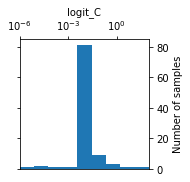

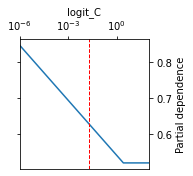

In [30]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(result_ens_opt, bins=10)
from skopt.plots import plot_objective
_ = plot_objective(result_ens_opt)


In [31]:
df_forest = pd.DataFrame(result_ens_opt.x_iters, columns=['final_estimator__C'])
df_forest['x'] = result_ens_opt.func_vals

In [32]:
df_forest.head(50)

,final_estimator__C,x
0,0.000,1.000
1,0.094,0.489
2,1.630,0.488
3,4.951,0.489
4,0.000,1.000
5,0.001,1.000
6,0.000,1.000
7,0.115,0.489
8,0.049,0.496
9,0.000,1.000


In [33]:
ens_opt.set_params(final_estimator__C=0.018202370448969933)
ens_opt.fit(X_ens_opt, np.ravel(y_train))

print('\nEnsemble results for fixed parameters: ')
l_results = tm_train.report_results(X_ens_opt, X_ens_opt_test, y_train, y_test, fitted_model=ens_opt, ready_probs=False, th=0)

print('\nFinal time: {}'.format(epoch2str(time.time())))



C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

Ensemble results for fixed parameters: 
train_auc: 0.6276, test_auc: 0.6072 (overfit: 0.0204)
train_f1:  0.5835, test_f1:  0.5657 (overfit: 0.0178)
train_f*:  0.5288, test_f*:  0.5209 (overfit: 0.0079)
--------
cm_train: 
[[3534 3497]
 [1710 3648]]
cm_test: 
[[953 827]
 [472 846]]
threshold: 0.500

Final time: [2021-06-09 22:26:02.596]
